# Lab Assignment 6

**Computer Vision** - Term 5, 2022

Instructor: Dr. Saumya Jetly <br>
TA: Ribhu Lahiri

*Deadline: Monday, 4 April 2022 11:59 pm* 

Submission form link: https://forms.gle/kDVnmzPdWGD3vYCS6

Total points: 5 (with potential extra credit)


In [2]:
import math
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn
from torchvision import datasets, transforms
from tqdm import tqdm

In [3]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epsilons = [0, .05, .1, .15, .2, .25, .3]

## Part 1 - Building the model [2 points]
In the first part, you will be building a CNN for classifying the CIFAR-10 dataset. By default, you can use AlexNet, but feel free to use more complex architectures if you want. 

**NOTE:** If you are facing issues training it, you can also use pre-trained weights, but you'll have to fine-tune it (transfer learning)

**Implement the `AlexNet`** *(2 points)*

In [4]:
dropout = 0.5

# AlexNet Model definition
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        # Architecture Goes here
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device(device)

# Initialize the network
model = AlexNet(num_classes=10).to(device)

# Hyper params
lr = 1e-3
epochs = 20
bs = 256

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().to(device)

CUDA Available:  True


In [5]:
# Load Data
train_transform = transforms.Compose([transforms.Resize(size=(64, 64)), transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize(size=(64, 64)), transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=bs, shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=bs, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [6]:
# Training Loop
for i in range(epochs):
  train_loss = 0
  train_correct = 0
  total = 0

  for batch_num, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      prediction = torch.max(output, 1)  # second param "1" represents the dimension to be reduced
      total += target.size(0)

      # train_correct incremented by one if predicted right
      train_correct += np.sum(prediction[1].cpu().numpy() == target.cpu().numpy())
  print('Loss: %.4f | Acc: %.3f%% (%d/%d)'
        % (train_loss / (batch_num + 1), 100. * train_correct / total, train_correct, total))


Loss: 2.0375 | Acc: 19.072% (9536/50000)
Loss: 1.6746 | Acc: 34.884% (17442/50000)
Loss: 1.4037 | Acc: 48.422% (24211/50000)
Loss: 1.2485 | Acc: 55.702% (27851/50000)
Loss: 1.1538 | Acc: 59.572% (29786/50000)
Loss: 1.0913 | Acc: 62.132% (31066/50000)
Loss: 1.0363 | Acc: 64.156% (32078/50000)
Loss: 0.9734 | Acc: 66.424% (33212/50000)
Loss: 0.9224 | Acc: 68.162% (34081/50000)
Loss: 0.8848 | Acc: 69.902% (34951/50000)
Loss: 0.8482 | Acc: 70.860% (35430/50000)
Loss: 0.8104 | Acc: 72.172% (36086/50000)
Loss: 0.7938 | Acc: 72.898% (36449/50000)
Loss: 0.7579 | Acc: 74.148% (37074/50000)
Loss: 0.7272 | Acc: 75.180% (37590/50000)
Loss: 0.6977 | Acc: 76.254% (38127/50000)
Loss: 0.6836 | Acc: 76.620% (38310/50000)
Loss: 0.6478 | Acc: 78.056% (39028/50000)
Loss: 0.6194 | Acc: 78.870% (39435/50000)
Loss: 0.6023 | Acc: 79.532% (39766/50000)


## Part 2 - FGSM (the attack) [1 point]
In this part, we will conduct a white-box adversarial attack known as **Fast Gradient Sign**. Rather than working to minimize the loss by adjusting the weights based on the backpropagated gradients, the attack adjusts the input data to **maximize** the loss based on the same backpropagated gradients.
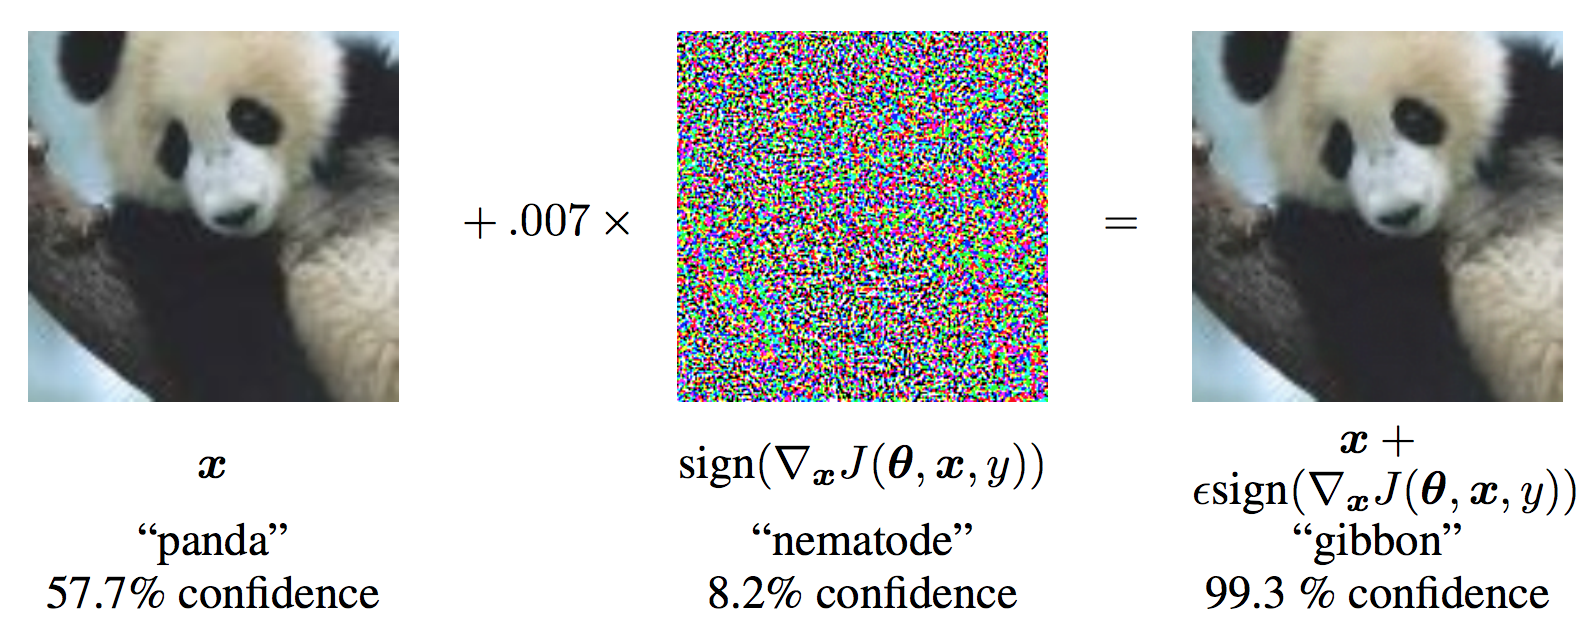

In [7]:
# To ensure model weights don't get updated
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

**Implement the `fgsm` method** *(1 point)*

In [1]:
def fgsm(image, epsilon, data_grad):
    # Collect gradient and create perturbed image
    # Add clipping to maintain range between 0 and 1
    # Return the perturbed image
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


In [8]:
def test(model, device, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in tqdm(test_loader):

        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        # If the initial prediction is wrong, dont bother attacking, just move on
        for i in range(data.shape[0]):
          if init_pred[i].item() != target[i].item():
              continue

          loss = F.nll_loss(output, target)
          model.zero_grad()
          loss.backward()
          data_grad = data.grad.data

          # Call FGSM Attack
          perturbed_data = fgsm(data, epsilon, data_grad)

          # Re-classify the perturbed image
          output = model(perturbed_data)

          # Check for success
          final_pred = output.max(1, keepdim=True)[1]
          if final_pred[i].item() == target[i].item():
              correct += 1
              # Special case for saving 0 epsilon examples
              if (epsilon == 0) and (len(adv_examples) < 5):
                  adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                  adv_examples.append((init_pred[i].item(), final_pred[i].item(), adv_ex) )
          else:
              # Save some adv examples for visualization later
              if len(adv_examples) < 5:
                  adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                  adv_examples.append( (init_pred[i].item(), final_pred[i].item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [9]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in tqdm(epsilons):
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

 14%|█▍        | 1/7 [03:18<19:48, 198.14s/it]

Epsilon: 0	Test Accuracy = 6721 / 40 = 168.025



 29%|██▊       | 2/7 [06:35<16:29, 197.97s/it]

Epsilon: 0.05	Test Accuracy = 3 / 40 = 0.075



 43%|████▎     | 3/7 [09:53<13:11, 197.90s/it]

Epsilon: 0.1	Test Accuracy = 0 / 40 = 0.0



 57%|█████▋    | 4/7 [13:11<09:53, 197.84s/it]

Epsilon: 0.15	Test Accuracy = 0 / 40 = 0.0



 71%|███████▏  | 5/7 [16:29<06:35, 197.80s/it]

Epsilon: 0.2	Test Accuracy = 0 / 40 = 0.0



 86%|████████▌ | 6/7 [19:46<03:17, 197.76s/it]

Epsilon: 0.25	Test Accuracy = 0 / 40 = 0.0



100%|██████████| 7/7 [23:04<00:00, 197.81s/it]

Epsilon: 0.3	Test Accuracy = 0 / 40 = 0.0


Here, you get a plot where you can see how increasing the epsilon affects test accuracy

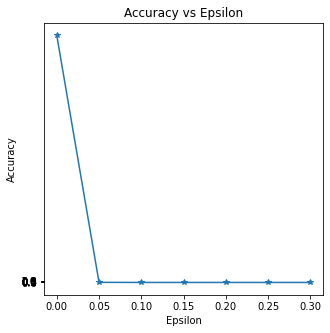

In [10]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Here, you get and idea how the epsilon values affect the images visually, and how the predictions change accordingly

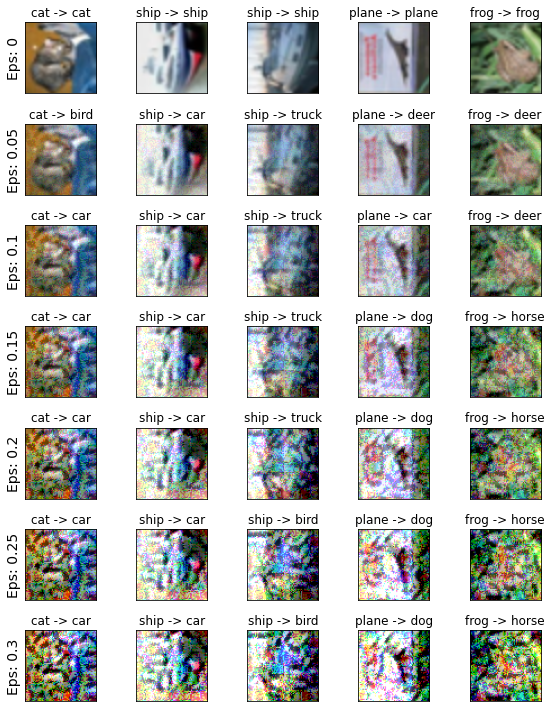

In [11]:
cnt = 0
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(classes[orig], classes[adv]))
        plt.imshow(ex[j].T, cmap="gray")
plt.tight_layout()
plt.show()

## Part 3 – Integrated Gradients [2 points]
In the final part of the lab, you need to use the captum library to use the Network Attribution method of Integrated Gradients. It allows us to interpret which pixels affect the prediction of the image for a specific class (whether correct or incorrect)

In [12]:
! pip install captum

     |████████████████████████████████| 1.4 MB 14.1 MB/s 


In [13]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

ind = 5

In [14]:
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs)
    return tensor_attributions

In [16]:
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

ind = 3
input = images[ind].unsqueeze(0)
input.requires_grad = True
input = input.to(device)

# Apply IntegratedGradients
ig = IntegratedGradients(model)
ig_attribution, delta = attribute_image_features(ig, input, baselines = input * 0, return_convergence_delta=True)
ig_attribution = np.transpose(ig_attribution.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([1.3124], device='cuda:0', dtype=torch.float64)


Original Image
Predicted: cat  Probability: 1.0


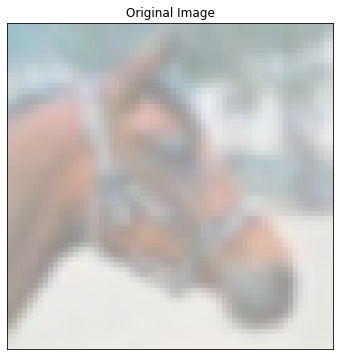

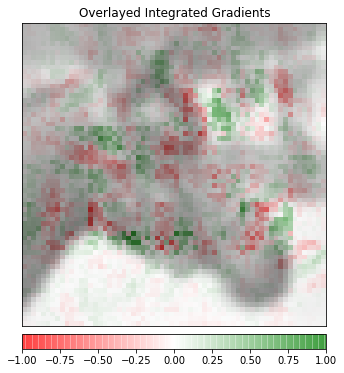

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3fe04aaa90>)

In [18]:
ind = 17

print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")
viz.visualize_image_attr(ig_attribution, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

**Extra Credit** (1 point)
Now that we are able to interpret how our model "sees" each class, and it is essentially a matrix of gradient values. Further, we created an adversarial attack which allows us to perturb our image to confuse the model. Is there a way we can use the Integrated Gradient attributions to direct the FGSM attack to a specific class. Create a new directed FGSM attack function to explore this possibility.